**Janus-Pro** is a unified understanding and generation MLLM, which decouples visual encoding for **multimodal understanding** and **generation**.

In [ ]:
!git clone https://github.com/deepseek-ai/Janus.git

In [2]:
%cd Janus

/content/Janus


In [ ]:
!pip install -e .

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

In [ ]:
# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B" #deepseek-ai/Janus-Pro-7B
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# Multimodal Understanding

In [13]:
question = """ Can you tell me what is in the image? """

conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\n{question}",
        "images": ["/content/images/invoice.webp"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

In [14]:
# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
 Can you tell me what is in the image?

<|Assistant|>: The image is a sample invoice template. It includes a header with a logo placeholder, a section for the invoice number, date, and address. Below that is a table with columns for "Invoice Number," "Date," "Description," "City," and "Price." The table lists various invoices with their respective details. At the bottom, there's a section for payment information, including a blank space for the name, bank, address, phone number, email, and website.


# Text-to-Image Generation

In [15]:
import os
import PIL.Image
import numpy as np

In [16]:
conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

In [17]:
sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

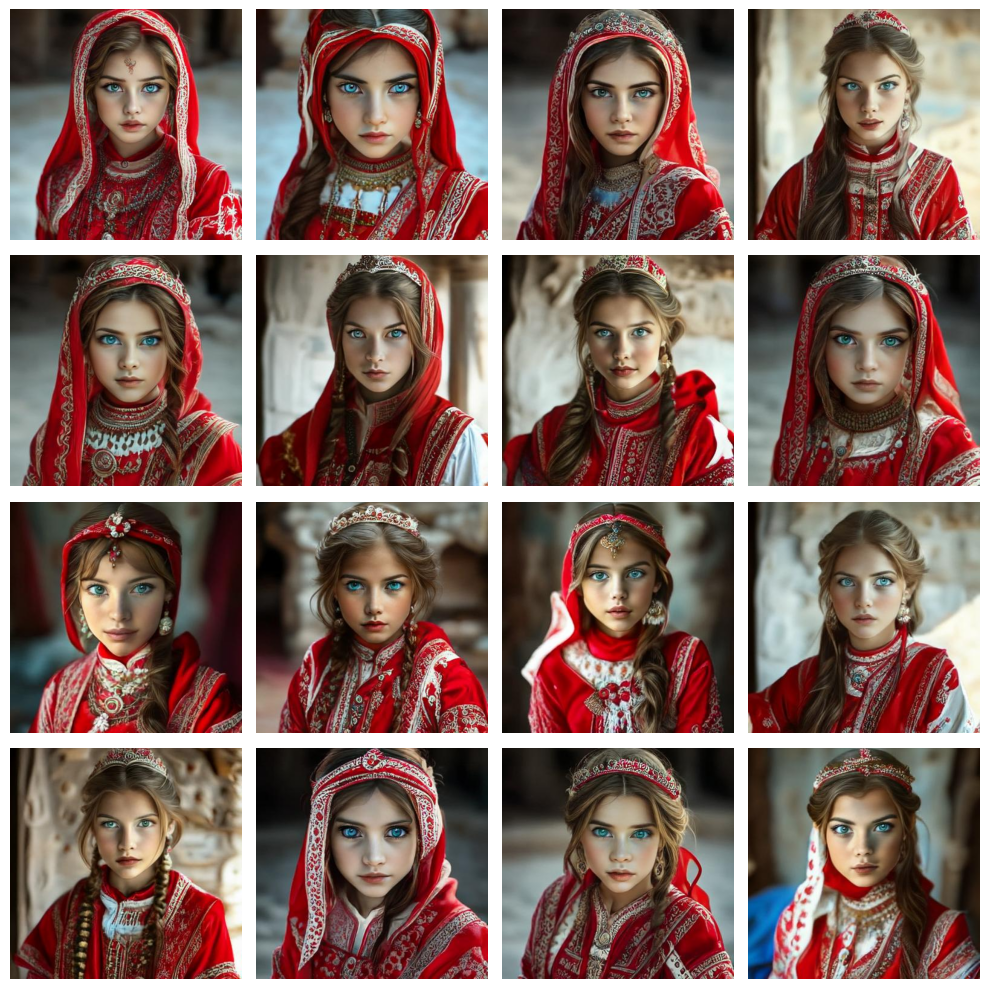

In [18]:
import PIL.Image
import matplotlib.pyplot as plt

parallel_size = 16
grid_size = int(np.sqrt(parallel_size))  # Assuming a square grid (4x4)

# Load images
image_dir = "generated_samples"
images = [PIL.Image.open(os.path.join(image_dir, f"img_{i}.jpg")) for i in range(parallel_size)]

# Create a figure
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Plot images in the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")  # Hide axis

plt.tight_layout()
plt.show()